In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [232]:
df_history =  pd.read_csv('article_views_synthetic_train.csv')
df_art = pd.read_csv('article_ids.csv')
df_test = pd.read_csv('article_views_synthetic_test.csv')

# EDA

Let's take a look at both datasets and its basic parameteres

In [49]:
df_history.head()

,user_id,article_id
0,6287,1
1,8095,3
2,2781,3
3,5624,3
4,372,3


The length of the dataframe after merge with the article should remain the same.

In [50]:
df_history.shape

(165746, 2)

In [51]:
df_art.head()

,title,article_id
0,another-record-year-for-inheritance-tax,286
1,save-000s-by-sending-money-abroad-online,1799
2,the-most-popular-isa-funds-in-2019,2016
3,understanding-mergers-and-acquisitions-why-com...,2228
4,mining-stocks-hit-as-copper-and-coal-fall-to-f...,1392


Creating "final" dataset to further exploration

In [52]:
df = pd.merge(df_history, df_art, how='inner', on='article_id')

In [53]:
df.head()

,user_id,article_id,title
0,6287,1,10-costly-pension-mistakes
1,8095,3,10-facts-investors-need-to-know-about-tesco-sa...
2,2781,3,10-facts-investors-need-to-know-about-tesco-sa...
3,5624,3,10-facts-investors-need-to-know-about-tesco-sa...
4,372,3,10-facts-investors-need-to-know-about-tesco-sa...


Seems like nothing is missing.

In [54]:
len(df) == len(df_history)

True

In [55]:
# Top 10 uesers
df.user_id.value_counts()[: 10]

4638    1163
4985    1042
4695     982
6150     956
7769     937
7849     806
6492     779
7018     735
2242     728
1258     712
Name: user_id, dtype: int64

In [56]:
# Top 10 articles

df.title.value_counts()[: 10]

next-week-on-the-stock-market                                                 1166
oil-and-stock-markets-fall-our-view                                           1074
woodford-our-view                                                              783
the-most-popular-stocks-and-shares-isa-funds-from-august-2020                  691
what-does-coronavirus-mean-for-investors                                       680
the-ukraine-crisis-what-it-means-for-investors                                 663
woodford-equity-income-all-dealing-suspended-following-redemption-concerns     646
3-better-performing-sectors-in-the-coronavirus-downturn                        645
woodford-equity-income-what-to-expect-now                                      639
five-shares-for-an-isa-2019                                                    580
Name: title, dtype: int64

In [57]:
df.isnull().sum()

user_id       0
article_id    0
title         2
dtype: int64

In [58]:
# If there are null values, replace them with a default value
df["title"].fillna("No title", inplace=True)

In [59]:
# Count the number of unique users and articles
unique_users = df["user_id"].unique()
unique_articles = df["article_id"].unique()

In [60]:
print("Total unique users:", len(unique_users))

Total unique users: 6905


In [61]:
print("Total unique articles:", len(unique_articles))

Total unique articles: 2482


In [56]:
df.user_id.value_counts()[:1000]

4638    1163
4985    1042
4695     982
6150     956
7769     937
        ... 
9729      37
7655      37
9288      37
6768      37
3977      37
Name: user_id, Length: 1000, dtype: int64

In [62]:
import nltk

# Import the stopwords library from NLTK
stopwords = nltk.corpus.stopwords.words("english")

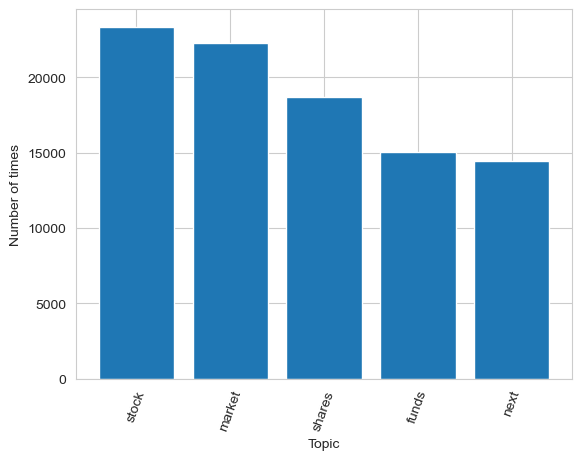

In [63]:
# Identify the most popular topics without stopwords
topic_counts = {}
for title in df["title"]:
    words = title.split("-")
    for word in words:
        if word not in stopwords:
            if word not in topic_counts:
                topic_counts[word] = 0
            topic_counts[word] += 1

popular_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)[:5]

# Create a DataFrame of the most popular topics
df_popular_topics = pd.DataFrame(popular_topics, columns=["Topic", "Count"])

# Create a bar chart of the most popular topics
sns.set_style('whitegrid')
plt.xticks(rotation=70)
plt.bar(df_popular_topics["Topic"], df_popular_topics["Count"])
plt.xlabel("Topic")
plt.ylabel("Number of times")
plt.show()

# TF-IDF

TF-IDF stands for term frequency–inverse document frequency. It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. TF-IDF is often used as a weighting factor in searches of information retrieval, text mining, and user modeling.

The TF-IDF score is calculated by multiplying two metrics:

- Term frequency (TF): This is the number of times a word appears in a document.
- Inverse document frequency (IDF): This is a measure of how common a word is in a corpus. 
<br></br>
The TF-IDF score is higher for words that appear frequently in a document but are not common in the corpus. This means that these words are more likely to be important to the document.

Considering we have many values which are repeating we need to limit our dataframe for the titles with only unique elements.

In [58]:
df.title = df.title.str.replace('-', ' ')

In [59]:
df.title

0                                10 costly pension mistakes
1         10 facts investors need to know about tesco sa...
2         10 facts investors need to know about tesco sa...
3         10 facts investors need to know about tesco sa...
4         10 facts investors need to know about tesco sa...
                                ...                        
165741                         your isa questions, answered
165742                         your isa questions, answered
165743                         your isa questions, answered
165744                         your isa questions, answered
165745                         your isa questions, answered
Name: title, Length: 165746, dtype: object

In [60]:
df_title = df.drop_duplicates(subset=['title', 'article_id'])
df_title = df_title[['article_id', 'title']] 
df_title.set_index('article_id', inplace=True)

In [61]:
df_title

,title
article_id,
1,10 costly pension mistakes
3,10 facts investors need to know about tesco sa...
4,10 most popular funds for isas last month
5,10 most popular isa funds in august
6,10 most popular isa funds in december
...,...
2544,you dont have to be old or rich to have a pension
2545,your 2022 financial plan 3 times to call in th...
2546,your five minute guide to real estate investme...


In [62]:
tfidf = TfidfVectorizer(stop_words='english')

# In case if we have any missing values. We have in fact 2 in title feature
df_title['title'] = df_title['title'].fillna("")

tfidf_matrix = tfidf.fit_transform(df_title['title'])

Let's find cosine similarity between words in `tfidf_matrix`

In [63]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [64]:
indices = pd.Series(df_title.index, index=df_title['title']).drop_duplicates()

In [65]:
indices

title
10 costly pension mistakes                                                                                       1
10 facts investors need to know about tesco sainsburys and morrisons                                             3
10 most popular funds for isas last month                                                                        4
10 most popular isa funds in august                                                                              5
10 most popular isa funds in december                                                                            6
                                                                                                              ... 
you dont have to be old or rich to have a pension                                                             2544
your 2022 financial plan 3 times to call in the experts                                                       2545
your five minute guide to real estate investment trusts reits and why inco

In [66]:
indices[2]

4

In [67]:
def get_recommendation(idx, cosine_sim = cosine_sim):
        
    sim_scores = enumerate(cosine_sim[idx])
    
    sim_scores = sorted(sim_scores, key=lambda x : x[1], reverse=True)
    
    sim_scores = sim_scores[1: 11]
    
    sim_scores = sim_scores[1: min(len(df_title), 11)]  # Adjust the slice based on df_title size
    
    sim_index = [i[0] for i in sim_scores]
    
    return sim_index

In [68]:
get_recommendation(4)

[5, 2016, 1382, 1965, 1381, 1383, 1384, 1683, 2]

In [71]:
df_title.title.iat[2016]

'the tax years 10 most popular isa funds'

In [182]:
test_idx = get_recommendation(4)

In [183]:
df[df.article_id.isin(test_idx)]

,user_id,article_id,title
15,3389,5,10 most popular isa funds in august
16,8066,5,10 most popular isa funds in august
17,942,5,10 most popular isa funds in august
18,942,5,10 most popular isa funds in august
19,2663,5,10 most popular isa funds in august
...,...,...,...
127120,5795,2016,the most popular isa funds in 2019
127121,2302,2016,the most popular isa funds in 2019
127122,5374,2016,the most popular isa funds in 2019
127123,1750,2016,the most popular isa funds in 2019


In [233]:
df_test = df_test[df_test.article_id.isin(df_title.index)]

In [ ]:
df_test['recommendations'] = df_test['article_id'].apply(lambda idx: get_recommendation(idx, cosine_sim))

# Content-Based Filtering

In order to make this work we need to introduce raiting somehow to the data we use. This can be artificially done by applying count of views for each article.

In [2]:
df_history =  pd.read_csv('article_views_synthetic_train.csv')
df_art = pd.read_csv('article_ids.csv')
df_test = pd.read_csv('article_views_synthetic_test.csv')
df = pd.merge(df_history, df_art, how='inner', on='article_id')
df.title = df.title.str.replace('-', ' ')

In [3]:
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
df['rating'] = df.groupby('article_id')['article_id'].transform('count')

In [5]:
df.head()

,user_id,article_id,title,rating
0,6287,1,10 costly pension mistakes,1
1,8095,3,10 facts investors need to know about tesco sa...,6
2,2781,3,10 facts investors need to know about tesco sa...,6
3,5624,3,10 facts investors need to know about tesco sa...,6
4,372,3,10 facts investors need to know about tesco sa...,6


In [26]:
# Article ID to article title mapping
article_names = df.set_index('article_id')['title'].to_dict()
n_users = len(df['user_id'].unique())
n_articles = len(df['article_id'].unique())
print('Number of unique users:', n_users)
print("Number of unique articles:", n_articles)
print("The full rating matrix will have:", n_users*n_articles, 'elements.')
print("--------")
print("Number of ratings:", len(df))
print("Therefore: ", len(df) / (n_users * n_articles) * 100, '% of matrix is filled.')
print("We have incredibly sparse matrix to work with here.")
print("And... as you can imagine, as the number of users and products grow, the number of elements will increase by n*2")
print("You are going to need a lot of memory to work with global scale... storing a full matrix in memory would be a challenge.")
print("One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data.")

Number of unique users: 6905
Number of unique articles: 2482
The full rating matrix will have: 17138210 elements.
--------
Number of ratings: 165746
Therefore:  0.9671138351088007 % of matrix is filled.
We have incredibly sparse matrix to work with here.
And... as you can imagine, as the number of users and products grow, the number of elements will increase by n*2
You are going to need a lot of memory to work with global scale... storing a full matrix in memory would be a challenge.
One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data.


In [7]:
# Define the MatrixFactorization class
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_articles, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.article_factors = torch.nn.Embedding(n_articles, n_factors)
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.article_factors.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        users, articles = data[:, 0], data[:, 1]
        return (self.user_factors(users) * self.article_factors(articles)).sum(1)
        
    def predict(self, user_ids, article_ids):
        user_factors = self.user_factors(torch.tensor(user_ids))
        article_factors = self.article_factors(torch.tensor(article_ids))
        return torch.sum(user_factors * article_factors, dim=1)

In [8]:
# creating the dataloader (necessary for pytorch)
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader # package that helps transform your data to machine learning readiness

In [9]:
# Define the DataLoader
class Loader(Dataset):
    def __init__(self, df, n_users, n_articles):
        self.ratings = df.copy()
        self.userid2idx = {o: i for i, o in enumerate(df['user_id'].unique())}
        self.articleid2idx = {o: i for i, o in enumerate(df['article_id'].unique())}
        self.ratings['user_id'] = df['user_id'].apply(lambda x: self.userid2idx[x])
        self.ratings['article_id'] = df['article_id'].apply(lambda x: self.articleid2idx[x])
        self.x = self.ratings[['user_id', 'article_id']].values
        self.y = self.ratings['rating'].values
        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y, dtype=torch.float32)
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return len(self.ratings)

In [10]:
# Set hyperparameters
num_epochs = 128
batch_size = 128
learning_rate = 1e-3
n_factors = 8

# Create the model and DataLoader
model = MatrixFactorization(n_users, n_articles, n_factors=n_factors)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_set = Loader(df, n_users, n_articles)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [11]:
# Train the model
for epoch in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Epoch #{}".format(epoch), "Loss:", sum(losses) / len(losses))

C:\Users\egoog\AppData\Local\Temp\ipykernel_14972\3014734162.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(num_epochs)):


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch #0 Loss: 79585.97273467664
Epoch #1 Loss: 77918.59106539575
Epoch #2 Loss: 75117.07668315637
Epoch #3 Loss: 71541.43100868726
Epoch #4 Loss: 67417.22991976351
Epoch #5 Loss: 62922.45958011583
Epoch #6 Loss: 58216.25145994208
Epoch #7 Loss: 53448.153865528475
Epoch #8 Loss: 48755.03949837114
Epoch #9 Loss: 44245.401904862454
Epoch #10 Loss: 40000.2186859013
Epoch #11 Loss: 36063.91574113176
Epoch #12 Loss: 32461.435597022803
Epoch #13 Loss: 29198.98487346163
Epoch #14 Loss: 26258.806550509773
Epoch #15 Loss: 23625.603408919524
Epoch #16 Loss: 21274.638341955237
Epoch #17 Loss: 19181.8653486215
Epoch #18 Loss: 17317.32080681407
Epoch #19 Loss: 15652.914386386945
Epoch #20 Loss: 14166.717526468992
Epoch #21 Loss: 12837.980617308156
Epoch #22 Loss: 11648.888771793558
Epoch #23 Loss: 10585.050445485944
Epoch #24 Loss: 9637.50006145934
Epoch #25 Loss: 8787.561692921996
Epoch #26 Loss: 8023.161072295789
Epoch #27 Loss: 7336.323735276153
Epoch #28 Loss: 6716.62372203223
Epoch #29 Loss: 6

In [12]:
# By training the model, we will have tuned latent factors for movies and users.
c = 0
uw = 0
aw = 0 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if c == 0:
            uw = param.data
            c +=1
        else:
            aw = param.data
        #print('param_data', param_data)

user_factors.weight tensor([[2.6139, 2.5877, 2.5687,  ..., 2.5968, 2.5819, 2.5844],
        [2.5741, 2.6139, 2.6155,  ..., 2.5914, 2.6100, 2.6019],
        [2.6352, 2.6100, 2.5880,  ..., 2.5870, 2.5928, 2.5955],
        ...,
        [2.5747, 2.5798, 2.6048,  ..., 2.5807, 2.5876, 2.6016],
        [2.5888, 2.6035, 2.6250,  ..., 2.5895, 2.6262, 2.6139],
        [2.5717, 2.6116, 2.5784,  ..., 2.5787, 2.6070, 2.5752]])
article_factors.weight tensor([[0.0822, 0.0470, 0.0835,  ..., 0.0391, 0.0769, 0.0779],
        [0.2863, 0.2845, 0.2799,  ..., 0.2818, 0.2988, 0.2601],
        [0.3856, 0.4154, 0.3997,  ..., 0.3715, 0.4063, 0.3615],
        ...,
        [0.6040, 0.5563, 0.5344,  ..., 0.5704, 0.5770, 0.5878],
        [0.7358, 0.7065, 0.7094,  ..., 0.7307, 0.7085, 0.7504],
        [0.2302, 0.2508, 0.2255,  ..., 0.2408, 0.2399, 0.2605]])


In [13]:
# Get the trained article embeddings
trained_article_embeddings = model.article_factors.weight.data.numpy()

In [14]:
trained_article_embeddings

array([[0.08220757, 0.04704269, 0.08354402, ..., 0.03908075, 0.0768569 ,
        0.07787406],
       [0.28629875, 0.28450143, 0.27993223, ..., 0.28176308, 0.29877087,
        0.26009586],
       [0.3855626 , 0.41537502, 0.3996837 , ..., 0.37154964, 0.4063375 ,
        0.36146083],
       ...,
       [0.6040157 , 0.5562786 , 0.53443664, ..., 0.57041556, 0.57700217,
        0.5877844 ],
       [0.73580897, 0.706459  , 0.709423  , ..., 0.7306917 , 0.70850235,
        0.7503565 ],
       [0.23017117, 0.25082123, 0.2254594 , ..., 0.24079882, 0.23985678,
        0.26046526]], dtype=float32)

In [17]:
from sklearn.cluster import KMeans

# Fit KMeans clusters
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_article_embeddings)

C:\Users\egoog\anaconda3\envs\symantic_nlp\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
for cluster in range(10):
    print("Cluster #{}".format(cluster))
    articles_in_cluster = []
    for article_idx in np.where(kmeans.labels_ == cluster)[0]:
        if article_idx in train_set.articleid2idx:
            article_id = train_set.articleid2idx[article_idx]
            if article_id in article_names:
                article_title = article_names[article_id]
                rating_count = df[df['article_id'] == article_id].shape[0]
                articles_in_cluster.append((article_title, rating_count))
    for article in sorted(articles_in_cluster, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", article[0])

Cluster #0
	 negative oil price how, why, and what it means for investors
	 looking beyond the pandemic reasons for economic optimism
	 3 uk share ideas companies that could benefit from an economic rebound
	 five investment trusts to watch in 2021
	 negative interest rates what are they and why do they matter for investors
	 3 investment trusts for a stocks and shares isa
	 the folklore of the market investing lessons from the 1950s
	 the dangers of trying to catch a falling knife
	 uk stock market and funds review on the road to recovery
	 global funds quarterly review whats done well in 2020
Cluster #1
	 the ukraine crisis what it means for investors
	 ftse 350 next week
	 investing through lockdowns three shares that could withstand disruption
	 uk stock market and funds review hows the uk coping
	 2 dividend stocks to lift next years january blues
	 what were the most popular shares in 201819 tax year so far
	 3 investment trusts for a stocks and shares isa 2022
	 the ftse what is

In [33]:
cluster_articles = {cluster: [] for cluster in range(10)}

# Assign articles to clusters and store them in the dictionary
for article_idx, cluster_label in enumerate(kmeans.labels_):
    if article_idx in train_set.articleid2idx:
        article_id = train_set.articleid2idx[article_idx]
        if article_id in article_names:
            article_title = article_names[article_id]
            rating_count = df[df['article_id'] == article_id].shape[0]
            cluster_articles[cluster_label].append((article_title, rating_count))

# Semantic analysis

From those clusters we can identify whether user reads articles related to positive or negative events. This might potentially signalize that user can potentially sell stocks or buy new one. This TBD with domain experts.

In [51]:
from transformers import pipeline
import random

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

cluster_sentiments = {cluster: [] for cluster in range(10)}

for cluster, articles_info in cluster_articles.items():
    article_titles = [article_info[0] for article_info in articles_info]  # Collect all article titles

    # Take four random article titles for each cluster
    # This limitation is due to compute limitations but also could be wise solution from investment prospective
    sample_size = min(4, len(article_titles))
    random_titles = random.sample(article_titles, sample_size)

    combined_titles = ", ".join(random_titles)  # Combine article titles with comma separation
    sentiment_result = classifier([combined_titles])  # Classify the combined titles
    cluster_sentiments[cluster].append(sentiment_result[0]['label'])

for cluster, sentiments in cluster_sentiments.items():
    cluster_sentiment = sentiments[0]
    print(f"Cluster #{cluster+1} Sentiment: {cluster_sentiment}")

Cluster #1 Sentiment: NEGATIVE
Cluster #2 Sentiment: NEGATIVE
Cluster #3 Sentiment: POSITIVE
Cluster #4 Sentiment: NEGATIVE
Cluster #5 Sentiment: NEGATIVE
Cluster #6 Sentiment: POSITIVE
Cluster #7 Sentiment: POSITIVE
Cluster #8 Sentiment: POSITIVE
Cluster #9 Sentiment: NEGATIVE
Cluster #10 Sentiment: NEGATIVE
